In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pybedtools
import pandas as pd
from collections import defaultdict
from matplotlib.patches import Rectangle
from scipy.stats import zscore
from biodatatools.utils.common import json_load
import itertools
import gseapy as gp
from biodata.delimited import DelimitedWriter
import numpy as np
import sys
from pathlib import Path

In [45]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [4]:
sys.path.append(str(Path.cwd().parent))
import utils

In [60]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2 = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

# DE analysis

In [4]:
# Used for DPGP clustering; pancreas lineage only
# Do DE analysis at replicate level and then apply the DPGP model to data matrix at sample level

samples = ["SC5", "SC11", "SC6", "SC9"]
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [7]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [9]:
# Pairwise comparison between four timepoints

outputfile = f"{PROJECT_DIR_o}DE/pancreas/samples.txt"
results = [[labels[s][0]] for s in samples for rep in ["a", "b"]]
reps = [f"{s}{rep}" for s in samples for rep in ["a", "b"]]
df = pd.DataFrame(results, index=reps, columns=["Condition"])
df.to_csv(outputfile, sep="\t")

In [10]:
bws = {}
ks = ["pl", "mn"]
for r in reps:
	bws[r] = [f"/home/kl945/EnhancerAtlas/PROcap/Alignments/{r}_5{k}.bw" for k in ks]

In [26]:
# Keep elements found in these samples

outputfile = f"{PROJECT_DIR_o}DE/pancreas/elements.bed"
with DelimitedWriter(outputfile) as dw:
	for p, d in itertools.product(ps, ds):
		df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
		es = set(df[df[samples].sum(axis=1) >= 1].index)
		for e in es:
			dw.write(e.split("_"))

In [28]:
inputfile = f"{PROJECT_DIR_o}DE/pancreas/elements.bed"
outputfile = f"{PROJECT_DIR_o}DE/PROcap/raw_reads.txt"
utils.get_count_matrix(inputfile, outputfile, reps, bws)

# DPGP cluster

## Run DPGP

In [19]:
# Run DESeq2 in "Data_preprocessing/4.DESeq2.ipynb"

inputfile = f"{PROJECT_DIR_o}DE/pancreas/DE_elements.txt.gz"
df = pd.read_table(inputfile, header=None)
DE_elements = set(df[0])

In [21]:
p = "divergent"
d = "distal"
df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
es = set(df[df[samples].sum(axis=1) >= 1].index)

In [23]:
# Get normalized count matrix of selected regions for DPGP clustering

df_exp = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/norm_reads_vst_all.txt", index_col=0)
outputfile = f"{PROJECT_DIR_o}DE/pancreas/DE_elements_norm_reads.txt.gz"
df = df_exp[samples].loc[[e for e in DE_elements if e in es]].shape
df.to_csv(outputfile, sep="\t")

In [ ]:
# https://github.com/PrincetonUniversity/DP_GP_cluster
# Install in "DPGP" conda environment - python 3.6; pandas 0.25.3; ggplot2 3.3.6
# cd /fs/cbsuhy02/storage/yc2553/yc2553/softwares/DP_GP_cluster
# python setup.py install

# Need to run the test in a different folder; otherwise will get "ImportError: cannot import name core"
# DP_GP_cluster.py -i /fs/cbsuhy02/storage/yc2553/yc2553/softwares/DP_GP_cluster/test/test.txt -o /fs/cbsuhy02/storage/yc2553/yc2553/softwares/DP_GP_cluster/test/test -p png -n 20 --plot

In [ ]:
# Made some modifications due to syntax changes between python 2 and 3

# cd "~/miniconda3_new/envs/DPGP/"
# "bin/DP_GP_cluster.py": add "()" to print statement
# "bin/DP_GP_cluster.py": line 617, changed to "for cluster, genes in optimal_cluster_labels.items():"

# "lib/python3.6/site-packages/Gpy/core/parameterization/priors.py": https://stackoverflow.com/questions/34777773/typeerror-object-takes-no-parameters-after-defining-new; line 366, changed to "o = super(Prior, cls).__new__(cls)"

# "lib/python3.6/site-packages/DP_GP/plot.py": line 73, changed to "IDs_split = [IDs[i:i+subplots_per_fig] for i in range(0, len(IDs), subplots_per_fig)]"

In [ ]:
# Get clusters based on dynamic profiles of PRO-cap
# We don't have biological replicates, so no need to run DP-GP timeseries clustering with replicate reproducibility as described in Kim et al.

In [26]:
# conda activate DPGP
# cd /home/yc2553/projects/HEA/codes/Fig.2_supps/timeseries
# This takes hours...

" ".join(["python timeseries.py",
			"--prefix PROcap",
			"--outdir", f"{PROJECT_DIR_o}DPGP/",
			"--inputfile", f"{PROJECT_DIR_o}DE/pancreas/DE_elements_norm_reads.txt.gz",
			"--size_cutoff 0.02"
			])

'python timeseries.py --prefix PROcap --outdir /home/yc2553/projects/HEA/output/DPGP/ --inputfile /home/yc2553/projects/HEA/output/DE/pancreas/DE_elements_norm_reads.txt.gz --size_cutoff 0.02'

In [27]:
inputfile = f"{PROJECT_DIR_o}DPGP/full/hard/reordered/PROcap.full.hard.reordered.clustering.txt"
df_cluster = pd.read_table(inputfile)
len(df_cluster)

16023

## Heatmap (logFC)

In [40]:
# Use logFC relative to ESCs from DESeq2

pairs = [f"{'_'.join(labels[s][0].split(' '))}_over_H9_ESCs" for s in samples[1:]]
dfs = [pd.read_table(f"{PROJECT_DIR_o}DE/pancreas/{pair}_resultsAll.txt.gz") for pair in pairs]
df_FC = pd.concat([df[["log2FoldChange"]] for df in dfs], axis=1)
df_FC.columns = samples[1:]
df_FC = df_FC.loc[list(df_cluster["id"])]
df_FC.head(2)

,SC11,SC6,SC9
chr2_209307246_209307481,-4.905329,-5.860654,-4.923805
chr1_160410525_160411089,-2.735721,-1.400225,-1.608787


In [30]:
colors = ["#80b1d3", "#FFFFFF", "#fb8072"]
cmap = plt.cm.colors.LinearSegmentedColormap.from_list("custom_pastel", colors)

In [55]:
def cluster_heatmap(df_FC, last_indices, vlims=[-2,2]):
	fig, ax = plt.subplots(figsize=(2,8))
	vmin, vmax = vlims
	g = sns.heatmap(df_FC, cmap=cmap, yticklabels=False, 
							vmin=vmin, vmax=vmax, ax=ax)
	g.xaxis.set_ticks_position('top')
	g.xaxis.set_label_position('top')
	g.set_xticklabels(["Endodermal cells", "Pancreatic progenitor cells", "Insulin producing beta-like cells"],
					    rotation=45, ha='left', rotation_mode='anchor', fontsize=bfontsize
					)

	g.set_ylabel("Dynamically transcribed elements", fontsize=bfontsize)
	
	g.collections[0].colorbar.remove()
	cbar_ax = fig.add_axes([1.2, 0.9, 0.5, 0.02])
	cbar = plt.colorbar(g.collections[0], cax=cbar_ax, orientation="horizontal")
	cbar.set_ticks([vmin, 0, vmax])
	cbar.set_ticklabels([vmin, 0, vmax], fontsize=sfontsize)
	cbar.set_label("logFC relative to ESC", fontsize=sfontsize)
	# fig.text(1.75, 0.95, "logFC relative to ESC", ha='center', va='center', fontsize=sfontsize)
	
	for n in last_indices:
		g.axhline(y=n+1, color="black", linewidth=1)
	
	xmin, xmax, ymin, ymax = g.get_xlim()[0], g.get_xlim()[1], g.get_ylim()[0], g.get_ylim()[1]
	rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=3, edgecolor='black', facecolor='none')
	g.add_patch(rect)
	
	return g

<Axes: ylabel='Dynamically transcribed elements'>

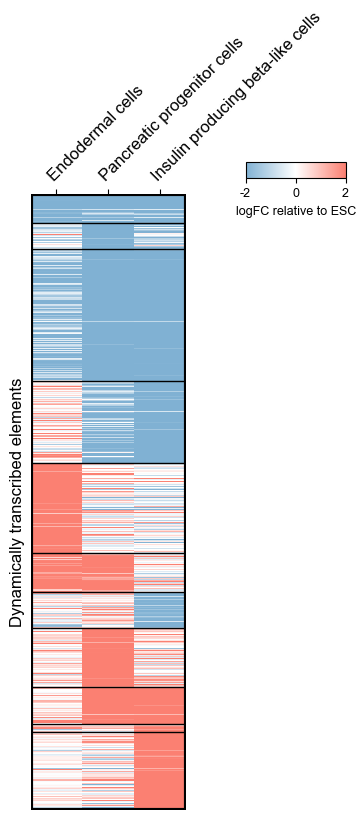

In [56]:
reversed_list = list(df_cluster["cluster"])[::-1]
last_indices = [len(reversed_list) - 1 - reversed_list.index(x) for x in range(np.max(df_cluster["cluster"]),0,-1)][::-1]
cluster_heatmap(df_FC, last_indices)

# Functional enrichment of gene sets

## Get target genes

In [61]:
inputfile = f"{PROJECT_DIR_d2}ENCODE/rna_expression_report_H9.tsv"
df = pd.read_table(inputfile, low_memory=False, header=1)
id_mapping = {}
for index, row in df.iterrows():
	if "ENSG" in row["Feature ID"]:
		id_mapping[row["Feature ID"]] = row["Gene symbol"]
	else:
		if "tRNAscan" not in row["Feature ID"] and "gSpikein" not in row["Feature ID"]:
			print(row["ID"].split("/")[-2], row["Feature ID"])

In [62]:
# Get a background set of genes (TPM > 1 in at least one replicate) for each timepoint

rna_encode = {"SC5": ["ENCFF274WSK", "ENCFF216CFE"],
			  "SC11": ["ENCFF599HQU", "ENCFF643LBM"],
			  "SC6": ["ENCFF111ORO", "ENCFF411UJX"],
			  "SC9": ["ENCFF299BMI", "ENCFF206GDB"]
			 }
background_genes = defaultdict(set)
for s in samples:
	for id in rna_encode[s]:
		inputfile = f"{PROJECT_DIR_d2}ENCODE/{id}.tsv"
		df = pd.read_table(inputfile)
		gs = df[df["TPM"]>1]["gene_id"]
		background_genes[s] |= set([id_mapping[g] for g in gs if g in id_mapping])
	print(s, len(background_genes[s]))

SC5 13494
SC11 14245
SC6 14615
SC9 15572


In [63]:
# Get genomic coordinates of expressed genes

inputfile = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/ABC-Enhancer-Gene-Prediction/reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed"
df = pd.read_table(inputfile, header=None)
for s in samples:
	df2 = df[df[3].isin(background_genes[s])]
	outputfile = f"{PROJECT_DIR_o}DE/pancreas/expressed_genes_{s}.bed"
	df2.to_csv(outputfile, header=None, index=False, sep="\t")
	print(s, len(df2))

SC5 12254
SC11 12686
SC6 12996
SC9 14121


In [68]:
# Assign elements to the closest expressed genes

b1 = pybedtools.BedTool(f"{PROJECT_DIR_o}DE/pancreas/elements.bed").sort()
for s in samples:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}DE/pancreas/expressed_genes_{s}.bed").sort()
	closest = b1.closest(b2)
	closest.saveas(f"{PROJECT_DIR_o}DE/pancreas/closest_genes_{s}.bed")

In [69]:
e2g_closest = defaultdict(dict)
for s in samples:
	inputfile = f"{PROJECT_DIR_o}DE/pancreas/closest_genes_{s}.bed"
	df = pd.read_table(inputfile, header=None)
	for _, row in df.iterrows():
		e = "_".join([row[0], str(row[1]), str(row[2])])
		gene = row[6]
		e2g_closest[s][e] = gene

## Pathway enrichment

In [57]:
cluster_timing = {
				  "SC5": [[3]],
				  "SC11": [[5,6]],
				  "SC6": [[8]],
				  "SC9": [[9,10,11]]
				 }

In [70]:
# Closest genes

genes = defaultdict(set)
for s in cluster_timing:
	for group in cluster_timing[s]:
		for k in group:
			es = list(df_cluster[df_cluster["cluster"]==k]["id"])
			for e in es:
				genes[(s, tuple(group))].add(e2g_closest[s][e])
		print(s, tuple(group), len(genes[(s, tuple(group))]))

SC5 (3,) 2269
SC11 (5, 6) 2231
SC6 (8,) 1251
SC9 (9, 10, 11) 2151


In [72]:
dfs = {}
gmt = f"{PROJECT_DIR_d2}GSEA/c2.cp.reactome.v2024.1.Hs.symbols.gmt"
for k in genes:
	enr = gp.enrich(gene_list=list(genes[k]),
					background=background_genes[k[0]],
					 gene_sets=gmt,
					 verbose=True
					 )
	dfs[k] = enr.results

2025-09-20 20:38:11,382 [INFO] User defined gene sets is given: /fs/cbsuhy02/storage/yc2553/yc2553/databases/GSEA/c2.cp.reactome.v2024.1.Hs.symbols.gmt
2025-09-20 20:38:11,445 [INFO] Run: c2.cp.reactome.v2024.1.Hs.symbols.gmt 
2025-09-20 20:38:11,448 [INFO] ['WARS2', 'VRTN', 'GPR176', 'PCOLCE2']
2025-09-20 20:38:11,449 [INFO] ['BTBD7', 'PCOLCE2', 'PTOV1', 'SNUPN']
2025-09-20 20:38:11,936 [INFO] Done.
2025-09-20 20:38:11,950 [INFO] User defined gene sets is given: /fs/cbsuhy02/storage/yc2553/yc2553/databases/GSEA/c2.cp.reactome.v2024.1.Hs.symbols.gmt
2025-09-20 20:38:11,974 [INFO] Run: c2.cp.reactome.v2024.1.Hs.symbols.gmt 
2025-09-20 20:38:11,976 [INFO] ['R3HCC1', 'HIF3A', 'HIVEP2', 'SOX5']
2025-09-20 20:38:11,978 [INFO] ['GALNT18', 'BTBD7', 'PTOV1', 'PCOLCE2']
2025-09-20 20:38:12,506 [INFO] Done.
2025-09-20 20:38:12,517 [INFO] User defined gene sets is given: /fs/cbsuhy02/storage/yc2553/yc2553/databases/GSEA/c2.cp.reactome.v2024.1.Hs.symbols.gmt
2025-09-20 20:38:12,532 [INFO] Run: c2.

In [75]:
dfs2 = []
for k in dfs:
	df = dfs[k][dfs[k]["Adjusted P-value"]<0.05].copy()
	if len(df) > 0:
		df["Gene_set"] = str(k)
		dfs2.append(df[["Gene_set", "Term", "Overlap", "Adjusted P-value"]])
df_merge = pd.concat(dfs2)
df_merge.head(2)

,Gene_set,Term,Overlap,Adjusted P-value
288,"('SC5', (3,))",REACTOME_DEVELOPMENTAL_BIOLOGY,185/845,0.015303
357,"('SC5', (3,))",REACTOME_EPHRIN_SIGNALING,10/18,0.031225


In [76]:
for k in dfs:
	print(k, [" ".join(term.split("_")[1:]).capitalize() for term in df_merge[df_merge["Gene_set"]==str(k)].sort_values(by="Adjusted P-value")["Term"]][:5])

('SC5', (3,)) ['Transcriptional regulation of pluripotent stem cells', 'Pou5f1 oct4 sox2 nanog activate genes related to proliferation', 'Stimuli sensing channels', 'Developmental biology', 'Eph ephrin mediated repulsion of cells']
('SC11', (5, 6)) ['Developmental biology', 'Rho gtpase cycle', 'Cdc42 gtpase cycle', 'Rhoa gtpase cycle', 'Formation of definitive endoderm']
('SC6', (8,)) ['Cell cell junction organization', 'Cell cell communication', 'Cell junction organization', 'Regulation of beta cell development', 'Developmental biology']
('SC9', (9, 10, 11)) ['Signaling by receptor tyrosine kinases', 'Developmental biology', 'Hemostasis', 'Signaling by rho gtpases miro gtpases and rhobtb3', 'Leishmania infection']


Text(4.3, 14426.1, 'Signaling by receptor tyrosine kinases\nSignaling by Rho GTPases Miro GTPases and RHOBTB3')

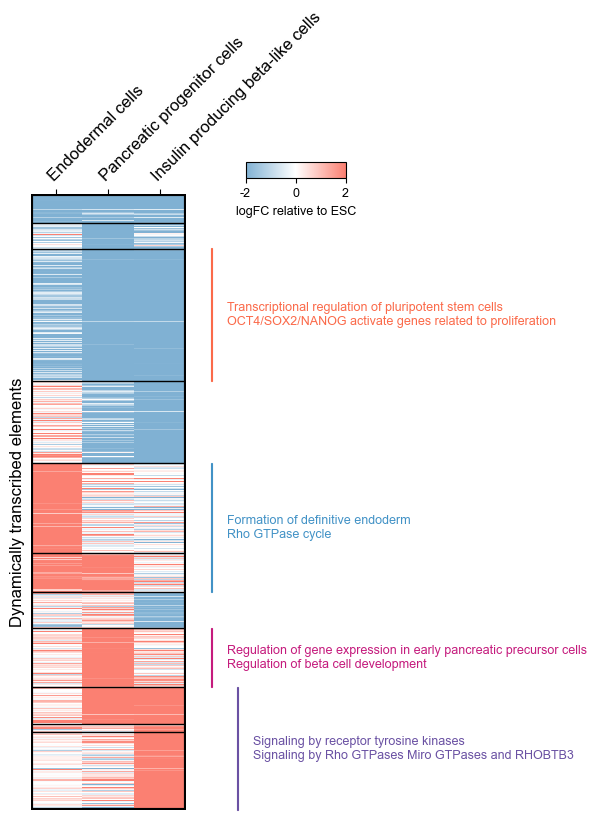

In [87]:
g = cluster_heatmap(df_FC, last_indices)
g.add_patch(Rectangle((3.5, last_indices[1]), 0.01, last_indices[2]-last_indices[1], fill=False, edgecolor="#fb6a4a", lw=lw, clip_on=False))
g.text(3.8, (last_indices[1]+last_indices[2])/2+0.1, "Transcriptional regulation of pluripotent stem cells\nOCT4/SOX2/NANOG activate genes related to proliferation", color="#fb6a4a", fontsize=sfontsize, va='center')

g.add_patch(Rectangle((3.5, last_indices[3]), 0.01, last_indices[5]-last_indices[3], fill=False, edgecolor="#4292c6", lw=lw, clip_on=False))
g.text(3.8, (last_indices[3]+last_indices[5])/2+0.1, "Formation of definitive endoderm\nRho GTPase cycle", color="#4292c6", fontsize=sfontsize, va='center')

g.add_patch(Rectangle((3.5, last_indices[6]), 0.01, last_indices[7]-last_indices[6], fill=False, edgecolor="#c51b7d", lw=lw, clip_on=False))
g.text(3.8, (last_indices[6]+last_indices[7])/2+0.1, "Regulation of gene expression in early pancreatic precursor cells\nRegulation of beta cell development", color="#c51b7d", fontsize=sfontsize, va='center')

g.add_patch(Rectangle((4, last_indices[7]), 0.01, last_indices[10]-last_indices[7], fill=False, edgecolor="#6a51a3", lw=lw, clip_on=False))
g.text(4.3, (last_indices[7]+last_indices[10])/2+0.1, "Signaling by receptor tyrosine kinases\nSignaling by Rho GTPases Miro GTPases and RHOBTB3", color="#6a51a3", fontsize=sfontsize, va='center')